In [ ]:
import os # 기본으로 설치 되어있음.
import re # 기본으로 설치 되어있음.
from pykospacing import Spacing
from sentence_transformers import SentenceTransformer, util
import pandas as pd 
import numpy as np
# import ace_tools as tools
import ace_tools_open as tools
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
from itertools import combinations # 기본으로 설치 되어있음.
from collections import defaultdict # 기본으로 설치 되어있음.
from konlpy.tag import Okt
#----------------------------------------------------------------
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [11]:
# ---------------------------------------공백 문제 해소 함수 정의
def rawdata_to_cleandata(data_file):
    # 파일 읽기
    with open(data_file, 'r', encoding='utf-8') as file:
        content = file.read()

    # 공백 제거 및 문장 분리
    content = "".join(content.split())
    sentences = re.split(r'[.!?]', content)

    # 빈 문장 제거 및 큰따옴표 제거
    clean_sentences = [re.sub(r'"', '', sentence) for sentence in sentences if sentence]

    # 공백 복원
    spacing = Spacing()
    spaced_sentences = [spacing(sentence.strip()) for sentence in tqdm(clean_sentences)]

    # 결과 저장 (입력 파일 이름 기반으로 저장)
    output_file_name = f"{os.path.splitext(os.path.basename(data_file))[0]}_cleaned.txt"
    output_file_path = os.path.join(os.path.dirname(data_file), output_file_name)
    
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        output_file.write("\n".join(spaced_sentences))
    
    return output_file_path

rawdata_to_cleandata("inho_data/소년이_온다.txt")
rawdata_to_cleandata("inho_data/채식주의자.txt")

  0%|          | 0/3683 [00:00<?, ?it/s]

100%|██████████| 3758/3758 [00:25<00:00, 149.91it/s]


'inho_data\\채식주의자_cleaned.txt'

In [12]:
#ㅡㅡㅡㅡㅡㅡㅡㅡㅡ----------------불용어 처리
def book_to_pkl_tokens(data_file):
    file_path = f"{data_file}"
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()  # 줄 단위로 읽기

    stopwords = {}

    okt = Okt()
    tokenized_sentences = []
    

    for idx, line in tqdm(enumerate(lines)):
        tokens_with_pos = okt.pos(line, stem=True)
        # 🔹 불용어 제거 + 조건 필터링 (예: 명사, 형용사, 동사만 유지, 길이 > 1)
        filtered_tokens = [
            word for word, pos in tokens_with_pos
            if word not in stopwords and len(word) > 1 and pos in ['Noun', 'Verb', 'Adjective']
        ]

        filtered_tokens = list(set(filtered_tokens))  # 중복 제거

        tokenized_sentences.append({
            "index": idx,
            "num_tokens": len(filtered_tokens),
            "tokens": filtered_tokens})

    output_file = f"inho_data/tokens_lines_{os.path.basename(data_file)}.pkl"
    with open(output_file, "wb") as f:
        pickle.dump(tokenized_sentences, f)

    return output_file
book_to_pkl_tokens("inho_data/소년이_온다_cleaned.txt")
book_to_pkl_tokens("inho_data/채식주의자_cleaned.txt")

3683it [00:05, 651.58it/s] 
3758it [00:03, 1087.66it/s]


'inho_data/tokens_lines_채식주의자_cleaned.txt.pkl'

In [13]:

import networkx as nx
from collections import defaultdict
def build_co_occurrence_network(pkl_file, window_size=2, top_n=10000):
    """
    동시출현 기반 의미망 구축
    :param window_size: 단어 동시출현 윈도우 크기 (문장 내)
    :param top_n: 상위 N개 노드만 선택
    :return: 네트워크 그래프 객체
    """
    with open(pkl_file, "rb") as f:
        data = pickle.load(f)
    
    # 단어 빈도 계산
    word_freq = defaultdict(int)
    co_occur = defaultdict(lambda: defaultdict(int))
    
    for sentence in data:
        words = sentence['tokens']
        for i in range(len(words)):
            word_freq[words[i]] += 1
            # 윈도우 내 동시출현 카운트
            start = max(0, i - window_size)
            end = min(len(words), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    co_occur[words[i]][words[j]] += 1
    
    # 상위 N개 단어 선택
    top_words = sorted(word_freq.items(), key=lambda x: -x[1])[:top_n]
    top_words = [word for word, freq in top_words]
    
    # 네트워크 생성
    G = nx.Graph()
    for word in top_words:
        G.add_node(word, size=word_freq[word])
    
    # 엣지 가중치 설정
    for word1 in top_words:
        for word2 in co_occur[word1]:
            if word2 in top_words and word1 != word2:
                weight = co_occur[word1][word2]
                G.add_edge(word1, word2, weight=weight)
    
    return G


# 의미망 생성
g1 = build_co_occurrence_network("inho_data/tokens_lines_소년이_온다_cleaned.txt.pkl")
g2 = build_co_occurrence_network("inho_data/tokens_lines_채식주의자_cleaned.txt.pkl")



In [14]:
def compare_networks(G1, G2,save_path="inho_data/common_nodes.txt"):
    """
    두 네트워크 비교 분석
    """
    common_nodes = set(G1.nodes) & set(G2.nodes)
    print(f"공통 노드 수: {len(common_nodes)}")
    print(f"공통 노드 상위 100개: {sorted(common_nodes, key=lambda x: -G1.nodes[x]['size'])[:100]}")
    
    # 유사도 지표
    jaccard_similarity = len(common_nodes) / len(set(G1.nodes) | set(G2.nodes))
    print(f"자카드 유사도: {jaccard_similarity:.4f}")
    # 이거는 다 분석을 하는거 같은데
    with open(save_path, "w", encoding="utf-8") as f:
        for node in common_nodes:
            f.write(f"{node}\n")
compare_networks(g1, g2)


공통 노드 수: 2433
공통 노드 상위 100개: ['하다', '있다', '않다', '그녀', '사람', '이다', '없다', '당신', '되다', '얼굴', '보다', '같다', '우리', '들다', '가다', '생각', '오다', '소리', '나오다', '아니다', '그렇다', '어떻다', '서다', '모르다', '죽다', '누나', '걸다', '기억', '다시', '머리', '들어오다', '싶다', '되어다', '희다', '보이다', '앉다', '먹다', '들어가다', '받다', '여자', '고개', '때문', '돼다', '순간', '남자', '시작', '기다리다', '맞다', '사이', '나가다', '언니', '입다', '목소리', '엄마', '시간', '뜨다', '처음', '만나다', '묻다', '알다', '따르다', '나르다', '이제', '아래', '걷다', '거리', '버리다', '어디', '자신', '크다', '그때', '남다', '모두', '부르다', '작다', '나다', '하나', '대답', '자다', '아무', '죽이다', '열다', '여기', '넣다', '동안', '흐르다', '쓰다', '들리다', '저녁', '지금', '어리다', '누구', '사무실', '물다', '내다', '자리', '지켜보다', '혼자', '치다', '모습']
자카드 유사도: 0.3402


In [15]:
import fasttext
from gensim.models import KeyedVectors
from tqdm import tqdm

# 1. FastText 모델 로드
ft_model = fasttext.load_model("inho_data/cc.ko.300.bin")

# 2. 단어 리스트 가져오기 (에러 무시)
words = ft_model.get_words(on_unicode_error='ignore')

# 3. Gensim KeyedVectors 생성
kv_model = KeyedVectors(vector_size=ft_model.get_dimension())
kv_model.add_vectors(words, [ft_model.get_word_vector(w) for w in tqdm(words)])

# 4. 저장
kv_model.save("inho_data/cc.ko.300.kv")


# 한번의 가공 하는 과정이 필요하다
# 이거는 반드시 필요하다

100%|██████████| 2000000/2000000 [00:10<00:00, 194067.52it/s]


In [16]:
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import os

# 1. 모델 로드
model = KeyedVectors.load("inho_data/cc.ko.300.kv")

# 2. 단어 불러오기
with open("inho_data/common_nodes.txt", "r", encoding="utf-8") as f:
    words = [line.strip() for line in f if line.strip()]

# 3. 벡터 추출
valid_words = []
vectors = []

for word in tqdm(words, desc="단어 벡터 추출 중"):
    if word in model:
        valid_words.append(word)
        vectors.append(model[word])

# 4. 클러스터 수 자동 결정 (최소 5개, 최대 15개 또는 전체 수)
min_k = 5
max_k = min(15, len(vectors))  # 데이터가 너무 적을 경우 대비

best_score = -1
best_k = min_k
best_labels = None

for k in range(min_k, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(vectors)
    score = silhouette_score(vectors, labels)
    print(f"클러스터 수: {k}, 실루엣 점수: {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

# 5. 최적 클러스터 수로 재학습
print(f"\n✅ 최적 클러스터 수: {best_k}")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(vectors)

# 6. 클러스터 결과 정리
clusters = defaultdict(list)
for word, label in zip(valid_words, labels):
    clusters[label].append(word)

output_path = "inho_data/common_nodes_clusters_auto_min5.txt"
os.makedirs("inho_data", exist_ok=True)

with open(output_path, "w", encoding="utf-8") as f:
    for cluster_id, word_list in clusters.items():
        f.write(f"[클러스터 {cluster_id}] ({len(word_list)}개)\n")
        f.write(", ".join(word_list[:50]) + "\n\n")

# 7. CSV 저장
df = pd.DataFrame({"단어": valid_words, "클러스터": labels})
df.sort_values("클러스터", inplace=True)
df.to_csv("inho_data/common_nodes_cluster_result_auto_min5.csv", index=False, encoding="utf-8-sig")


단어 벡터 추출 중: 100%|██████████| 2433/2433 [00:00<00:00, 811123.25it/s]


클러스터 수: 5, 실루엣 점수: 0.0697
클러스터 수: 6, 실루엣 점수: 0.0709
클러스터 수: 7, 실루엣 점수: 0.0695
클러스터 수: 8, 실루엣 점수: 0.0750
클러스터 수: 9, 실루엣 점수: 0.0673
클러스터 수: 10, 실루엣 점수: 0.0672
클러스터 수: 11, 실루엣 점수: 0.0652
클러스터 수: 12, 실루엣 점수: 0.0657
클러스터 수: 13, 실루엣 점수: 0.0667
클러스터 수: 14, 실루엣 점수: 0.0664
클러스터 수: 15, 실루엣 점수: 0.0667

✅ 최적 클러스터 수: 8


C:\Users\USER\AppData\Local\Temp\ipykernel_10880\248349810.py:35: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10880\248349810.py:35: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10880\248349810.py:35: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10880\248349810.py:35: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10880\248349810.py:35: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10880\248349810.py:35: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) 

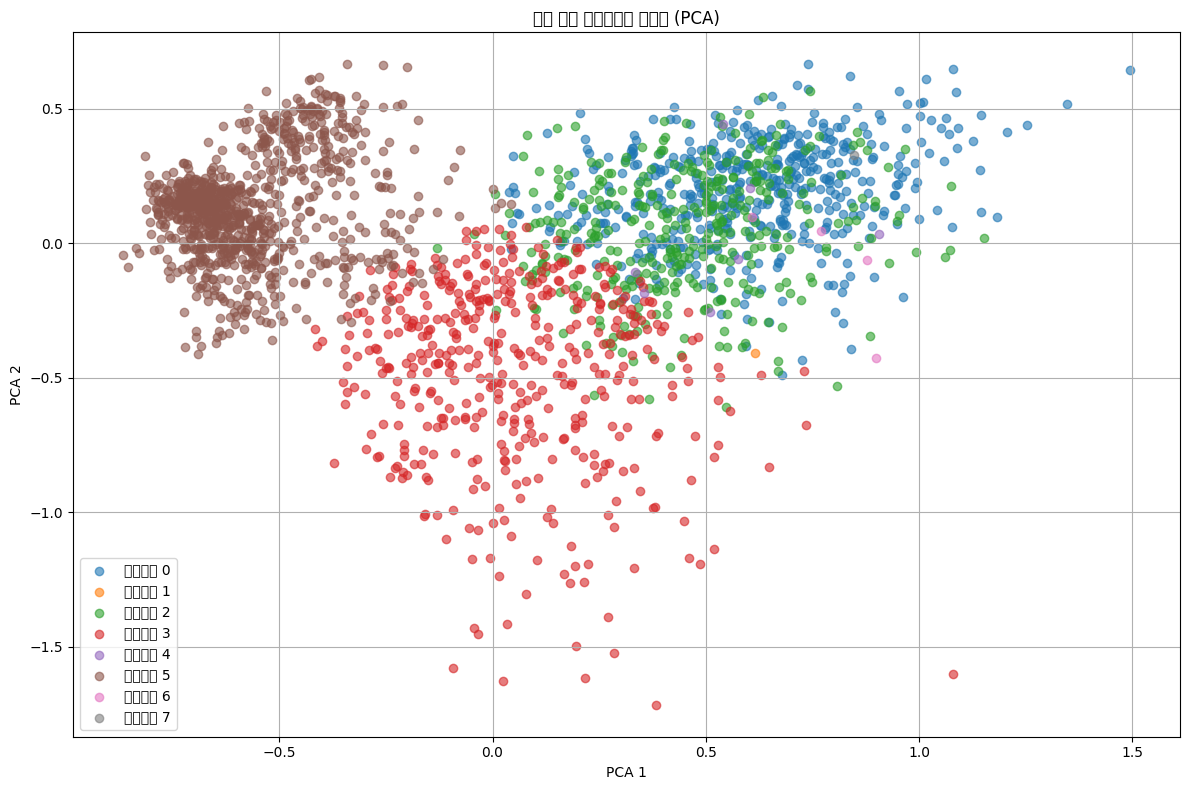

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors

# 1. CSV 파일 불러오기
df = pd.read_csv("inho_data/common_nodes_cluster_result_auto_min5.csv", encoding="utf-8-sig")

# 2. 모델 로드 (벡터값 추출용)
model = KeyedVectors.load("inho_data/cc.ko.300.kv")

# 3. 단어 벡터 다시 추출
vectors = [model[word] for word in df["단어"] if word in model]

# 4. PCA 차원 축소 (2차원)
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# 5. 시각화를 위한 데이터프레임 구성
df = df[df["단어"].isin(model.key_to_index)]  # 모델에 있는 단어만 필터링
df["x"] = reduced[:, 0]
df["y"] = reduced[:, 1]

# 6. 산점도 시각화
plt.figure(figsize=(12, 8))
for cluster_id in sorted(df["클러스터"].unique()):
    cluster_data = df[df["클러스터"] == cluster_id]
    plt.scatter(cluster_data["x"], cluster_data["y"], label=f"클러스터 {cluster_id}", alpha=0.6)

plt.title("공통 단어 클러스터링 시각화 (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
